In [1]:
import sys, os
import torch
import torch.nn as nn
import numpy as np
from torchvision import transforms
import tqdm
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [2]:
from sklearn.metrics import mean_squared_error

In [3]:
sys.path.append("../")

In [4]:
from Transformers import ChannelsFirst, ToTensor, Cut, Rescale, splitter, splitter_train_val_test

In [5]:
from DataSets import UNetDataSetFromNpz, UNetDatasetFromFolders

In [6]:
from cUNet_pytorch_pooling import cUNet, dice_loss

In [7]:
DATA_DIR_DEEPTHOUGHT="/storage/yw18581/data"
data_dir = DATA_DIR_DEEPTHOUGHT

In [8]:
model_name = "../model/trained_cUNet_regression_validation_50epochs_coeff_mask0.75_batch16_on_npz.pkl"

In [9]:
model_inference = cUNet(out_size=1)

In [10]:
model_inference.load_state_dict(torch.load(model_name))

<All keys matched successfully>

In [11]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#### Test trained model on 15mm

In [12]:
folder_15mm = os.path.join(data_dir,"dataset_15mm")

In [13]:
composed = transforms.Compose([Cut(),Rescale(.25), ChannelsFirst(), ToTensor()])

In [14]:
dataset_15mm = UNetDatasetFromFolders(folder_15mm, transform=composed)

In [15]:
data_loader_15mm = DataLoader(dataset_15mm, batch_size=16, shuffle=True, num_workers=4)

In [16]:
model_inference.eval()
model_inference.to(device);

cUNet(
  (conv_block_down1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (conv_block_down2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (conv_block_down3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (conv_block_down4): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (conv_block_d

batch 1
1: true_dist: 15, pred_dist: [15.479543]


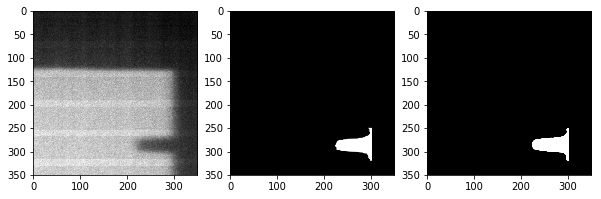

2: true_dist: 15, pred_dist: [15.399826]


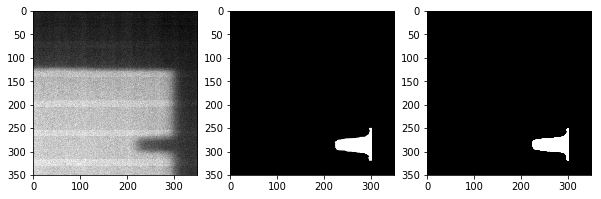

3: true_dist: 15, pred_dist: [15.290892]


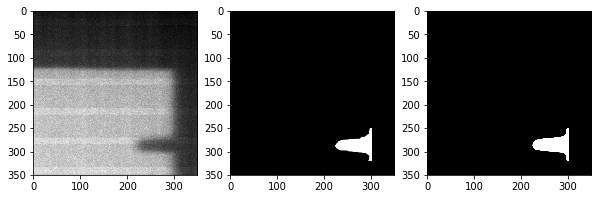

4: true_dist: 15, pred_dist: [15.377227]


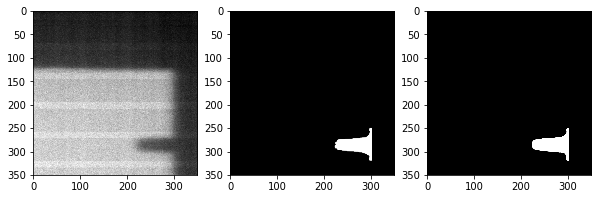

5: true_dist: 15, pred_dist: [15.402032]


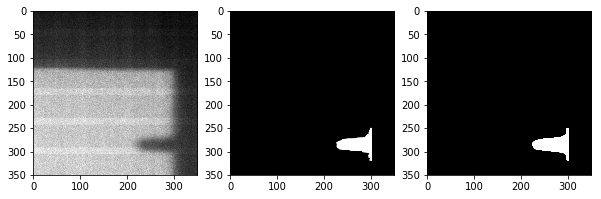

6: true_dist: 15, pred_dist: [15.403966]


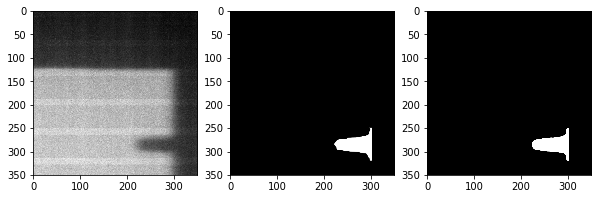

7: true_dist: 15, pred_dist: [15.548872]


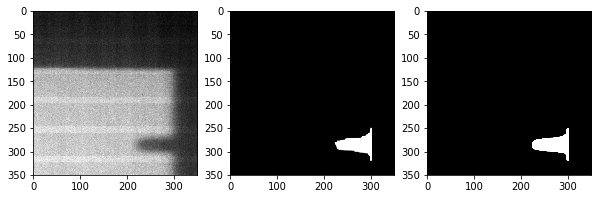

8: true_dist: 15, pred_dist: [15.357562]


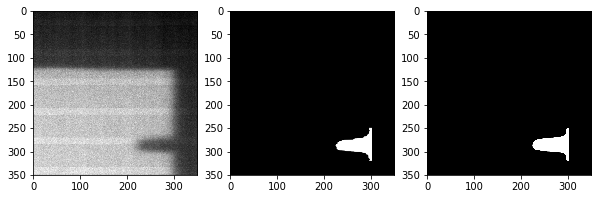

9: true_dist: 15, pred_dist: [15.55587]


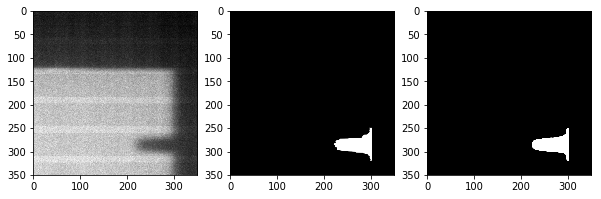

10: true_dist: 15, pred_dist: [15.434921]


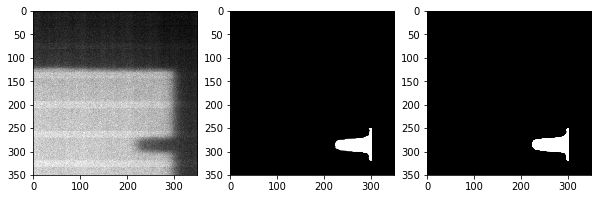

11: true_dist: 15, pred_dist: [15.335492]


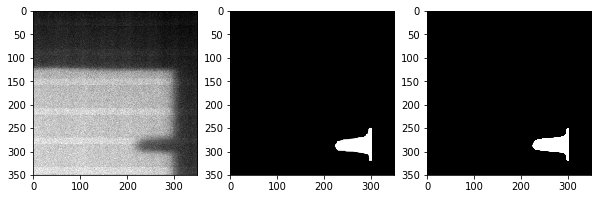

12: true_dist: 15, pred_dist: [15.481534]


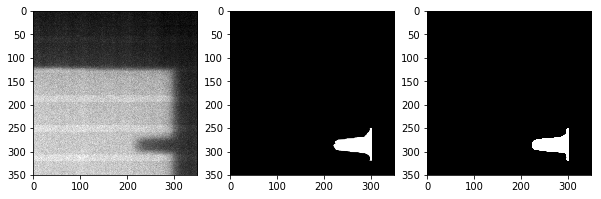

13: true_dist: 15, pred_dist: [15.404757]


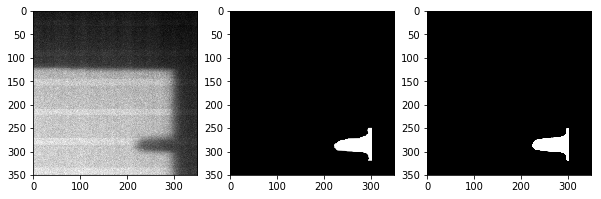

14: true_dist: 15, pred_dist: [15.487235]


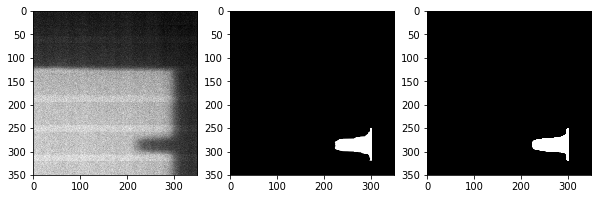

15: true_dist: 15, pred_dist: [15.2864685]


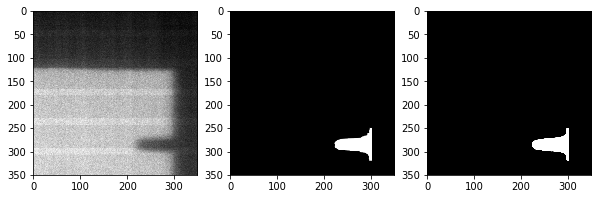

16: true_dist: 15, pred_dist: [15.305904]


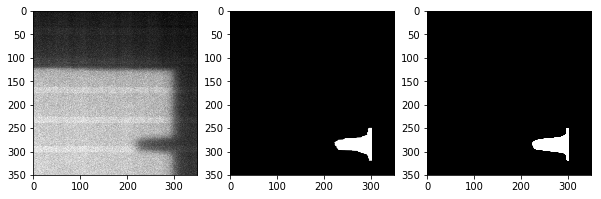

batch 2
1: true_dist: 15, pred_dist: [15.338506]


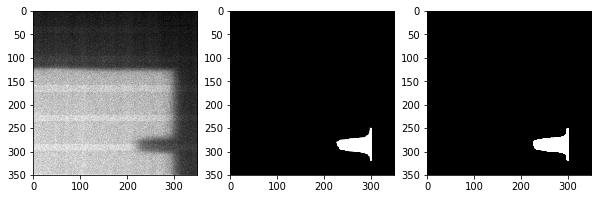

2: true_dist: 15, pred_dist: [15.442332]


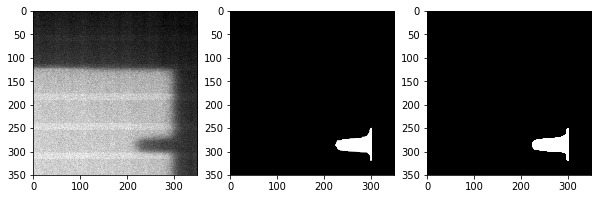

3: true_dist: 15, pred_dist: [15.280882]


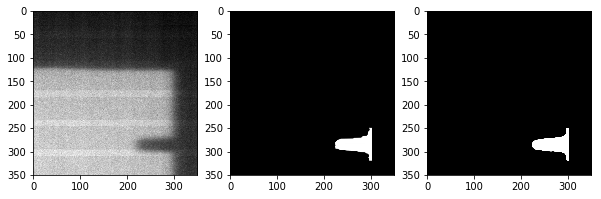

4: true_dist: 15, pred_dist: [15.434156]


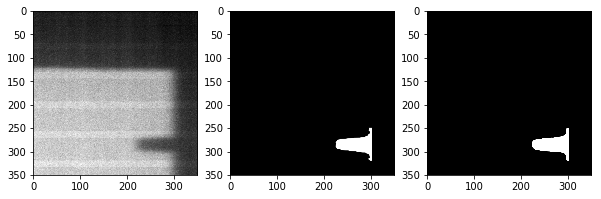

5: true_dist: 15, pred_dist: [15.370758]


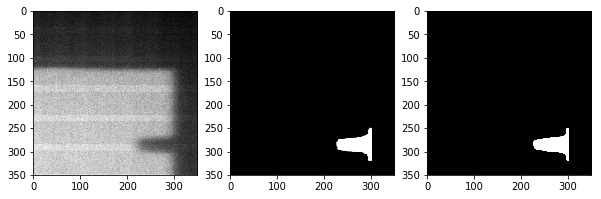

6: true_dist: 15, pred_dist: [15.441838]


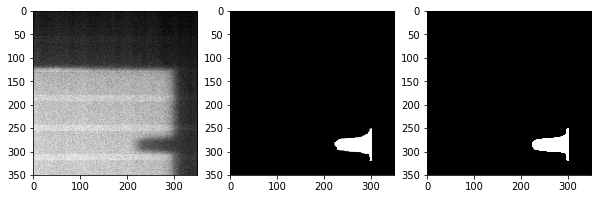

7: true_dist: 15, pred_dist: [15.218203]


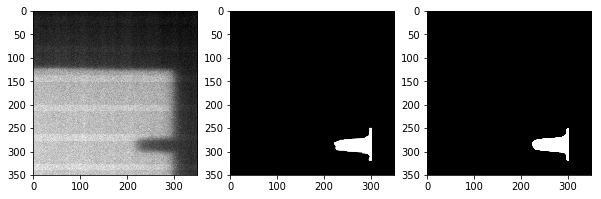

8: true_dist: 15, pred_dist: [15.52061]


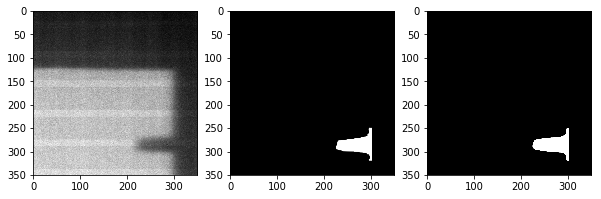

9: true_dist: 15, pred_dist: [15.471797]


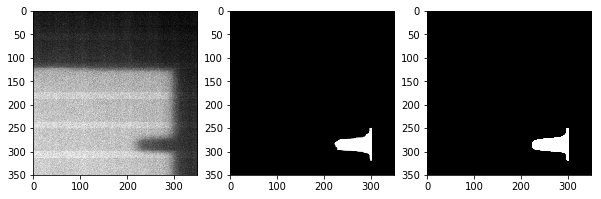

10: true_dist: 15, pred_dist: [15.368199]


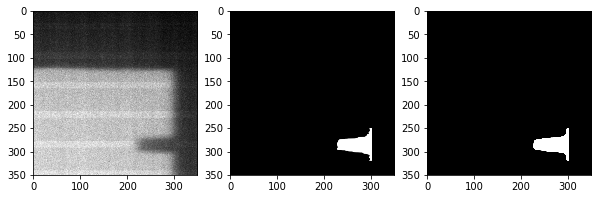

11: true_dist: 15, pred_dist: [15.2572365]


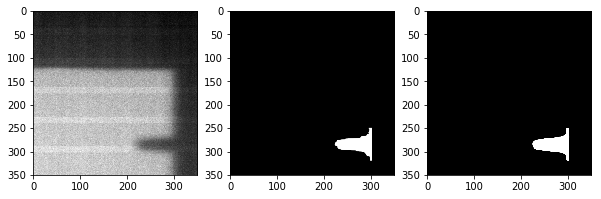

12: true_dist: 15, pred_dist: [15.567772]


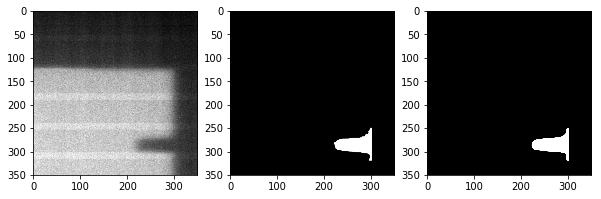

13: true_dist: 15, pred_dist: [15.382447]


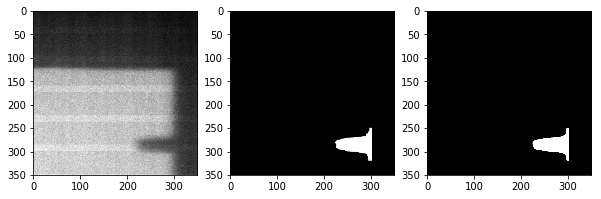

14: true_dist: 15, pred_dist: [15.291689]


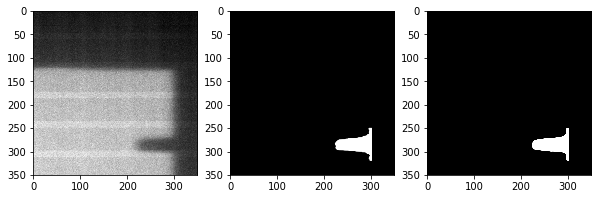

15: true_dist: 15, pred_dist: [15.429395]


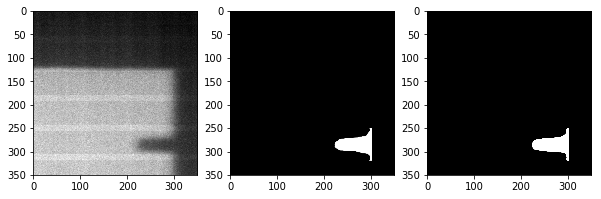

16: true_dist: 15, pred_dist: [15.507315]


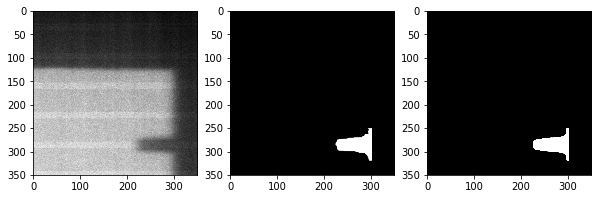

In [17]:
for i, batch in enumerate(data_loader_15mm):

    true_images, true_masks, true_dists = batch['image'], batch['mask'], batch['dist']
    pred_masks, pred_classes = model_inference(true_images.float().to(device))
    print("batch {}".format(i+1))
    for j, (img, tr_msk, tr_cl, pr_msk, pr_cl) in enumerate(zip(true_images,
                                                 true_masks, 
                                                 true_dists.cpu().detach().numpy(),
                                                 pred_masks.cpu().detach().numpy(), 
                                                 pred_classes.cpu().detach().numpy())):
    
        true_dist = tr_cl
        pred_dist = pr_cl
        print("{}: true_dist: {}, pred_dist: {}".format(j+1, true_dist, pred_dist))
        
        f = plt.figure(figsize=(10,5))
        f.add_subplot(1,3, 1)
        plt.imshow(img[0,...], cmap='gray')
        f.add_subplot(1,3, 2)
        plt.imshow(tr_msk[0,...], cmap='gray')
        f.add_subplot(1,3, 3)
        plt.imshow(pr_msk[0,...], cmap='gray')
        plt.show(block=True)
        
    if i==1:
        break

In [18]:
len(dataset_15mm)

900

In [19]:
y_true_15mm = []
y_pred_15mm = []

for i, batch in enumerate(data_loader_15mm):
    true_images, true_dists = batch['image'], batch['dist']
    _, pred_classes = model_inference(true_images.float().to(device))
    print("batch {}".format(i + 1))
    for j, (img, tr_cl, pr_cl) in enumerate(zip(true_images,
                                                true_dists.cpu().detach().numpy(),
                                                pred_classes.cpu().detach().numpy())):
        true_dist = tr_cl
        pred_dist = pr_cl
        y_true_15mm.append(true_dist)
        y_pred_15mm.append(pred_dist)




batch 1
batch 2
batch 3
batch 4
batch 5
batch 6
batch 7
batch 8
batch 9
batch 10
batch 11
batch 12
batch 13
batch 14
batch 15
batch 16
batch 17
batch 18
batch 19
batch 20
batch 21
batch 22
batch 23
batch 24
batch 25
batch 26
batch 27
batch 28
batch 29
batch 30
batch 31
batch 32
batch 33
batch 34
batch 35
batch 36
batch 37
batch 38
batch 39
batch 40
batch 41
batch 42
batch 43
batch 44
batch 45
batch 46
batch 47
batch 48
batch 49
batch 50
batch 51
batch 52
batch 53
batch 54
batch 55
batch 56
batch 57


In [20]:
y_pred_15mm = np.asarray(y_pred_15mm).ravel()
y_true_15mm = np.asarray(y_true_15mm)

print("mse: {}".format(mean_squared_error(y_true_15mm, y_pred_15mm)))

mse: 0.17270797638530488


In [22]:
np.savez_compressed(os.path.join(data_dir, "Predicted_15mm_ALL_out_model_trained_on_npz.npz"),
                   true = y_true_15mm, pred = y_pred_15mm)